In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-v0_8-darkgrid')

In [2]:
def brownien(T, n, nb_trajectoires=1, seed=None):
    """
    Simule des trajectoires de mouvement brownien standard.
    
    Paramètres:
    -----------
    T : float
        Temps final
    n : int
        Nombre de pas de temps
    nb_trajectoires : int
        Nombre de trajectoires à simuler
    seed : int, optional
        Graine aléatoire pour reproductibilité
        
    Retourne:
    ---------
    t : array
        Grille temporelle
    W : array
        Trajectoires browniennes (shape: (n+1, nb_trajectoires))
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Grille temporelle
    dt = T / n
    t = np.linspace(0, T, n+1)
    
    # Simulation des incréments browniens
    dW = np.sqrt(dt) * np.random.randn(n, nb_trajectoires)
    
    # Construction des trajectoires par somme cumulée
    W = np.zeros((n+1, nb_trajectoires))
    W[1:, :] = np.cumsum(dW, axis=0)
    
    return t, W

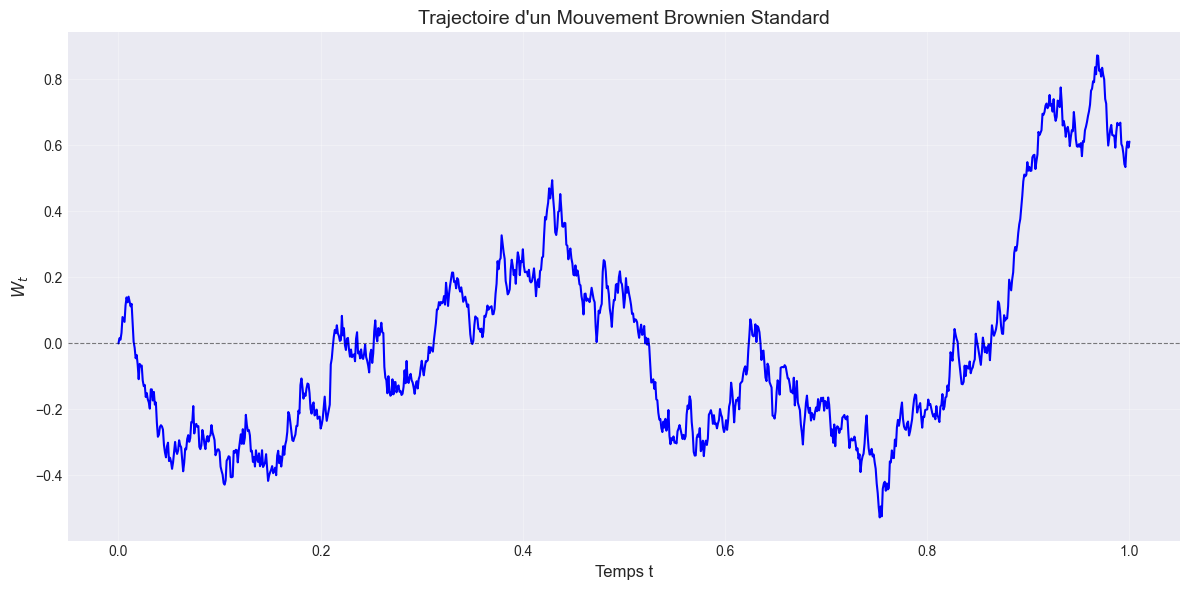

In [3]:
T = 1.0  # Temps final
n = 1000  # Nombre de pas

t, W = brownien(T, n, nb_trajectoires=1, seed=42)

plt.figure(figsize=(12, 6))
plt.plot(t, W, linewidth=1.5, color='blue')
plt.xlabel('Temps t', fontsize=12)
plt.ylabel('$W_t$', fontsize=12)
plt.title('Trajectoire d\'un Mouvement Brownien Standard', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()

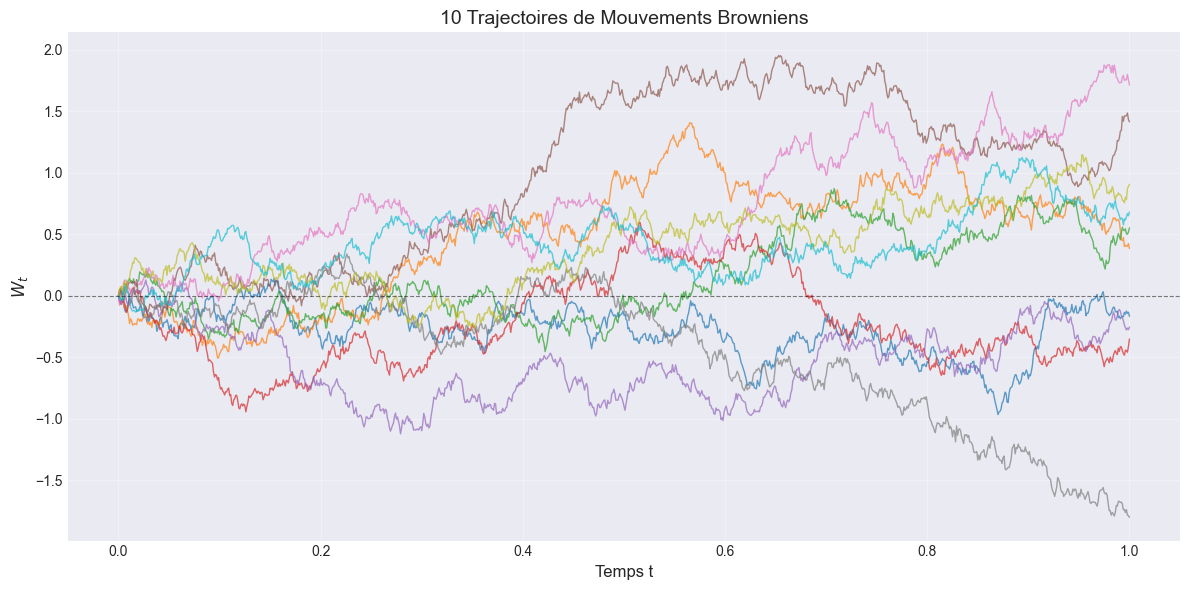

In [4]:
nb_traj = 10
t, W = brownien(T, n, nb_trajectoires=nb_traj, seed=123)

plt.figure(figsize=(12, 6))
for i in range(nb_traj):
    plt.plot(t, W[:, i], linewidth=1, alpha=0.7)
plt.xlabel('Temps t', fontsize=12)
plt.ylabel('$W_t$', fontsize=12)
plt.title(f'{nb_traj} Trajectoires de Mouvements Browniens', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()


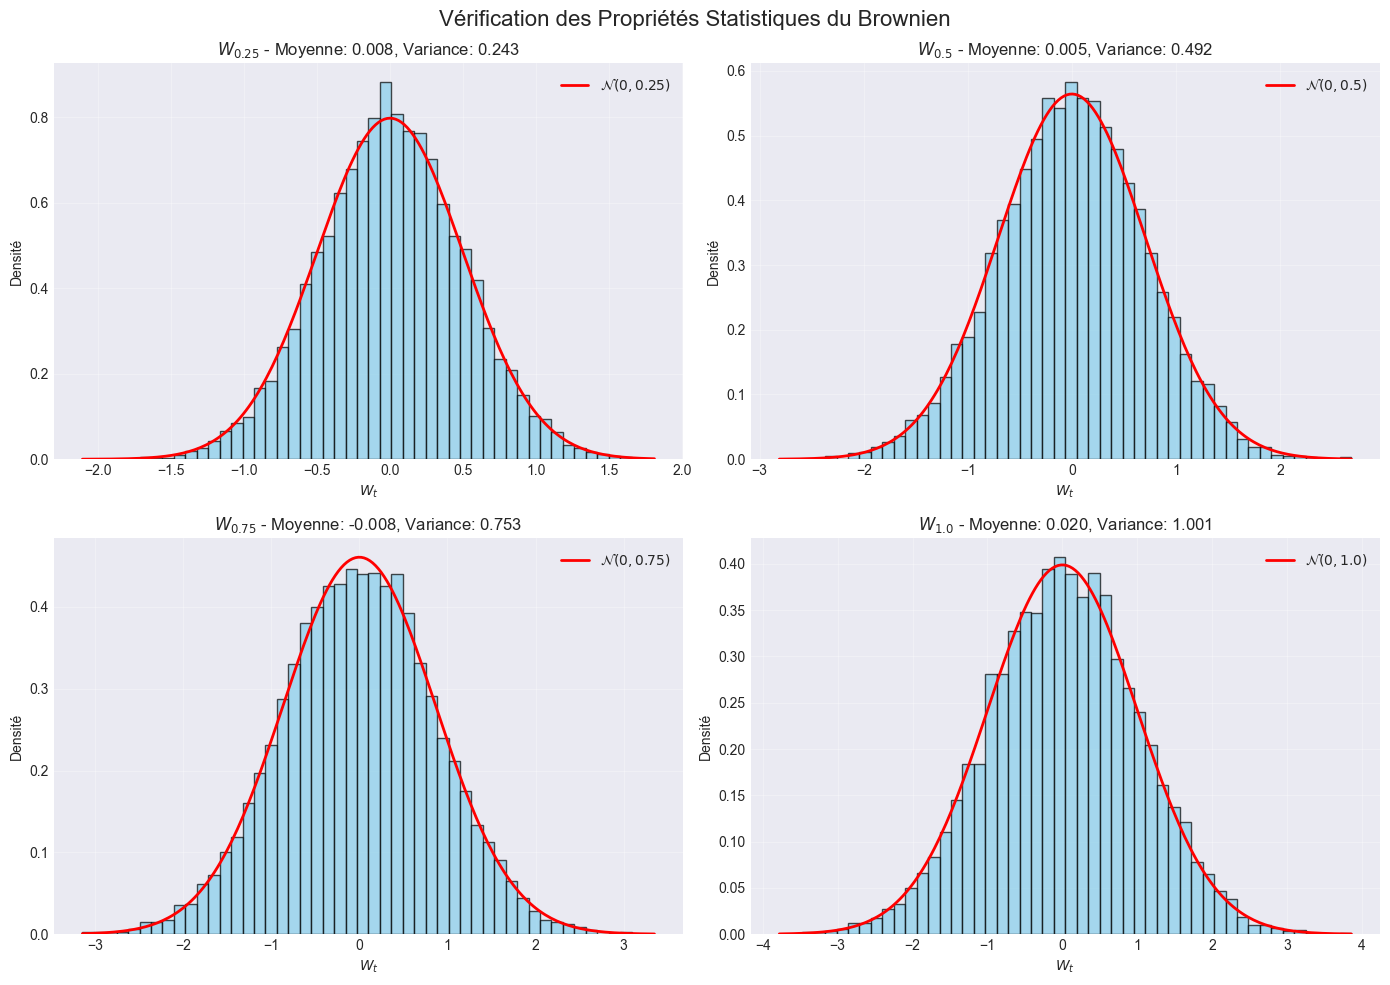

In [5]:
nb_simulations = 10000
t_check = np.array([0.25, 0.5, 0.75, 1.0])
n_check = 100

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Vérification des Propriétés Statistiques du Brownien', fontsize=16)

for idx, t_val in enumerate(t_check):
    ax = axes[idx // 2, idx % 2]
    
    # Simuler W_t pour ce temps spécifique
    _, W_sim = brownien(t_val, n_check, nb_trajectoires=nb_simulations, seed=idx)
    W_t = W_sim[-1, :]  # Valeur finale
    
    # Histogramme
    ax.hist(W_t, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Densité théorique N(0, t)
    x = np.linspace(W_t.min(), W_t.max(), 200)
    densite_theorique = (1 / np.sqrt(2 * np.pi * t_val)) * np.exp(-x**2 / (2 * t_val))
    ax.plot(x, densite_theorique, 'r-', linewidth=2, label=f'$\mathcal{{N}}(0, {t_val})$')
    
    # Statistiques empiriques
    mean_empirique = np.mean(W_t)
    var_empirique = np.var(W_t)
    
    ax.set_title(f'$W_{{{t_val}}}$ - Moyenne: {mean_empirique:.3f}, Variance: {var_empirique:.3f}', 
                 fontsize=12)
    ax.set_xlabel('$W_t$', fontsize=10)
    ax.set_ylabel('Densité', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


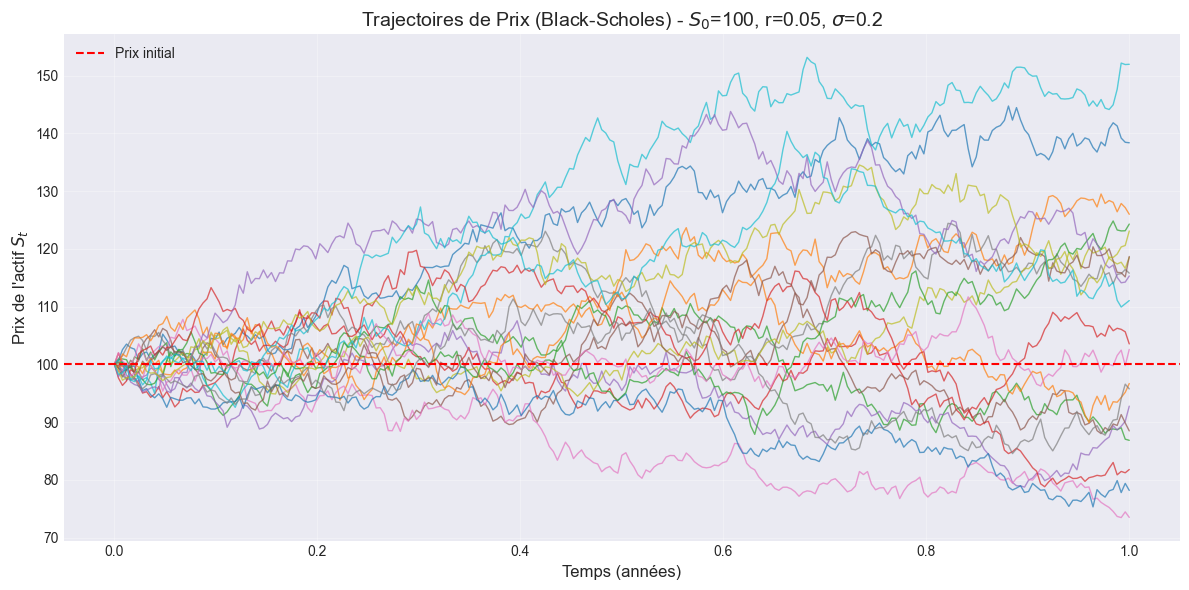

In [7]:
def black_scholes_trajectoire(S0, r, sigma, T, n, nb_trajectoires=1, seed=None):
    """
    Simule des trajectoires de prix selon le modèle de Black-Scholes.
    
    S_t = S_0 * exp((r - sigma^2/2)*t + sigma*W_t)
    """
    t, W = brownien(T, n, nb_trajectoires, seed)
    
    # Prix de l'actif
    S = S0 * np.exp((r - 0.5 * sigma**2) * t[:, np.newaxis] + sigma * W)
    
    return t, S

# Paramètres
S0 = 100  # Prix initial
r = 0.05  # Taux sans risque
sigma = 0.2  # Volatilité
T = 1.0
n = 252  # Jours de trading

t, S = black_scholes_trajectoire(S0, r, sigma, T, n, nb_trajectoires=20, seed=42)

plt.figure(figsize=(12, 6))
for i in range(20):
    plt.plot(t, S[:, i], linewidth=1, alpha=0.7)
plt.xlabel('Temps (années)', fontsize=12)
plt.ylabel('Prix de l\'actif $S_t$', fontsize=12)
plt.title(f'Trajectoires de Prix (Black-Scholes) - $S_0$={S0}, r={r}, $\sigma$={sigma}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=S0, color='red', linestyle='--', linewidth=1.5, label='Prix initial')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
def valoriser_option_call(S0, K, r, sigma, T, nb_simulations=10000):
    """
    Valorise une option d'achat européenne par Monte Carlo.
    
    Prix = E[exp(-rT) * max(S_T - K, 0)]
    """
    # Simuler S_T directement
    t, W = brownien(T, 1, nb_trajectoires=nb_simulations)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W[-1, :])
    
    # Payoff actualisé
    payoff = np.exp(-r * T) * np.maximum(S_T - K, 0)
    
    # Prix de l'option
    prix = np.mean(payoff)
    ic = 1.96 * np.std(payoff) / np.sqrt(nb_simulations)
    
    return prix, ic

K = 105  # Strike
prix, ic = valoriser_option_call(S0, K, r, sigma, T, nb_simulations=100000)

print(f"Prix de l'option call (Monte Carlo): {prix:.4f}")
print(f"Intervalle de confiance à 95%: [{prix - ic:.4f}, {prix + ic:.4f}]")

Prix de l'option call (Monte Carlo): 8.0389
Intervalle de confiance à 95%: [7.9571, 8.1206]
